<a href="https://colab.research.google.com/github/alyssa-raphaella/COMP8220/blob/master/Assessment/Assessed_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google Drive Connection

In [1]:
from google.colab import drive

# mount drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/COMP8220-GColab/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Import Libraries

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
%matplotlib inline

import random

import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers.normalization import BatchNormalization

import pandas as pd
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Caltech-101 Dataset

In [4]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

######################################################################## 100.0%
101_ObjectCategories  gdrive  images  sample_data


##### Remove 5 largest categories in the dataset

In [0]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

##### Load all images from root folder, then pre-process data into an image and input vector

In [0]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

# randomize data order
random.shuffle(data)

##### Split data to Training, Validation, and Test sets ( 70%, 15%, 15% )

In [0]:
num_data = len(data)

# data split (train, val, test)
train_split, test_split = 0.70, 0.85

idx_val = int(train_split * num_data)
idx_test = int(test_split * num_data)

train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

x_train, y_train = np.array([t['x'] for t in train]), [t['y'] for t in train]
x_val, y_val = np.array([t['x'] for t in val]), [t['y'] for t in val]
x_test, y_test = np.array([t['x'] for t in test]), [t['y'] for t in test]

##### Normalization of data and label conversion

In [0]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### CNN Architecture
##### Filters
* The model has 64 filters in the first convolutional layer, then doubled the number of filters after reducing the spatial dimension of the initial input with MaxPooling

##### Kernel Size
* The first convolutional layer has kernel size of (5,5) due to the input image size is 224 x 224 which is large
* Kernel Size of (3,3) for the second layer due to the MaxPooling outputs data that has size of 110 x 110, which is not that big, that's why the kernel size is reduced 

##### Padding
* _Same_ padding is used for the two layers to maintain the dimension of the input, which improves the performance of the architecture by keeping the information at the borders of the data 

#### Activation
* Activation used for all layers is _relu_ for computational efficiency, since images are being processed by the architecture

#### Regularizer
* L2 regularization was used with 0.01 value, to reduce the effects of overfitting

#### Dropout Layers
* 2 dropout layers were applied in the architecture to regularize the data
* The first dropout layer was placed before flattening the array, to regularize the data before flattening it
* The second layer was placed before the last dense layer, to regularize the data before the final processing of the data output

#### Dense Layers
* 3 dense layers were used, to reduce the input size and the computational complexity
* These dense layers were used in the architecture to reduce the computational complexity of the model, which leads to faster processing time
* The first two dense layers have 256 neurons, which is large enough considering the size of the input data
* 97 neurons were used in the last dense layer, because there are 97 expected ouputs for the Caltech-101 dataset

#### Softmax (activation)
* Softmax was used in the last layer of each architectural model in this notebook
* Softmax was used because it outputs the probability distribution of the image in each class, which gives better image classification compared to binary activation

### With Dropout Layers

In [9]:
model_1 = Sequential()
model_1.add(Conv2D(filters = 64, kernel_size= (5,5), padding = 'same', activation = "relu", input_shape = (224, 224, 3)))
model_1.add(MaxPooling2D(pool_size = (2,2)))

model_1.add(Conv2D(filters = 128, kernel_size =(3,3), padding = 'same', activation = "relu"))
model_1.add(MaxPooling2D(pool_size = (2,2)))
model_1.add(Dropout(0.25))

model_1.add(Flatten())
model_1.add(Dense(256, activation = "relu"))
model_1.add(Dense(256, activation = "relu", kernel_regularizer=keras.regularizers.l2(0.01)))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation = "softmax"))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [10]:
model_1.compile(optimizer = Adam(learning_rate = 3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 20)

Train on 4346 samples, validate on 931 samples
Epoch 1/20
4346/4346 [==============================] - 19s 4ms/step - loss: 6.2318 - accuracy: 0.0541 - val_loss: 5.3902 - val_accuracy: 0.0945
Epoch 2/20
4346/4346 [==============================] - 12s 3ms/step - loss: 4.8254 - accuracy: 0.1420 - val_loss: 4.3318 - val_accuracy: 0.2041
Epoch 3/20
4346/4346 [==============================] - 12s 3ms/step - loss: 3.7913 - accuracy: 0.2614 - val_loss: 3.6519 - val_accuracy: 0.2825
Epoch 4/20
4346/4346 [==============================] - 12s 3ms/step - loss: 2.8445 - accuracy: 0.4091 - val_loss: 3.2570 - val_accuracy: 0.3566
Epoch 5/20
4346/4346 [==============================] - 12s 3ms/step - loss: 1.9612 - accuracy: 0.5769 - val_loss: 3.2201 - val_accuracy: 0.3663
Epoch 6/20
4346/4346 [==============================] - 12s 3ms/step - loss: 1.2676 - accuracy: 0.7386 - val_loss: 3.4008 - val_accuracy: 0.3566
Epoch 7/20
4346/4346 [==============================] - 12s 3ms/step - loss: 0.8597

### Without Dropout Layers
* Same architecture was used, but dropout layers were removed

In [11]:
model_2 = Sequential()
model_2.add(Conv2D(filters = 64, kernel_size= (5,5), padding = 'same', activation = "relu", input_shape = (224, 224, 3)))
model_2.add(MaxPooling2D(pool_size = (2,2)))

model_2.add(Conv2D(filters = 128, kernel_size =(3,3), padding = 'same', activation = "relu"))
model_2.add(MaxPooling2D(pool_size = (2,2)))
#model_1.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(256, activation = "relu"))
model_2.add(Dense(256, activation = "relu", kernel_regularizer=keras.regularizers.l2(0.01)))
#model_1.add(Dropout(0.5))
model_2.add(Dense(num_classes, activation = "softmax"))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               102760704 
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

In [12]:
model_2.compile(optimizer = Adam(learning_rate = 3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 20)

Train on 4346 samples, validate on 931 samples
Epoch 1/20
4346/4346 [==============================] - 12s 3ms/step - loss: 6.0130 - accuracy: 0.1243 - val_loss: 4.9461 - val_accuracy: 0.2256
Epoch 2/20
4346/4346 [==============================] - 12s 3ms/step - loss: 3.8650 - accuracy: 0.3539 - val_loss: 3.8314 - val_accuracy: 0.3265
Epoch 3/20
4346/4346 [==============================] - 12s 3ms/step - loss: 2.0174 - accuracy: 0.6710 - val_loss: 3.7833 - val_accuracy: 0.3469
Epoch 4/20
4346/4346 [==============================] - 12s 3ms/step - loss: 0.8419 - accuracy: 0.9422 - val_loss: 4.3264 - val_accuracy: 0.3641
Epoch 5/20
4346/4346 [==============================] - 12s 3ms/step - loss: 0.5581 - accuracy: 0.9880 - val_loss: 4.7006 - val_accuracy: 0.3631
Epoch 6/20
4346/4346 [==============================] - 12s 3ms/step - loss: 0.4671 - accuracy: 0.9972 - val_loss: 4.5748 - val_accuracy: 0.3985
Epoch 7/20
4346/4346 [==============================] - 12s 3ms/step - loss: 0.4164

#### Test Loss and Accuracy
* There is no big difference between the loss and accuracy of the the two models
* Test Accuracy vary from 32% to 42%
* The model with dropout might have higher accuracy in one run, and higher accuracy with the model without dropout in another run, which is caused by the randomness in the input.

In [13]:
loss_1, accuracy_1 = model_1.evaluate(x_test, y_test, verbose=0)
loss_2, accuracy_2 = model_2.evaluate(x_test, y_test, verbose=0)

result_list = []
result_list.append(["with Dropout", loss_1, accuracy_1])
result_list.append(["without Dropout", loss_2, accuracy_2])

result_pd = pd.DataFrame(result_list, columns = ["Model", "Loss", "Accuracy"])
#result_pd = result_pd.set_index('Model')
result_pd

,Model,Loss,Accuracy
0,with Dropout,4.405936,0.386266
1,without Dropout,4.074606,0.420601


#### Validation Loss and Accuracy Plot
##### Loss
* Architecture with dropout layer achieved the lowest loss compared to the model without dropout layer for the validation set
* Dropout Layer gradually decreases the data loss per epoch
* Dropout also gradually increases the data loss per epoch, which is a sign of overfitting
* Early stopping resolves overfitting which may improve the performance of the models, but it was not used in this notebook to observe the behavior of the validation loss and validation accuracy of each model

##### Accuracy
* The model with dropout layer has gradually increased, then stabilized in a certain accuracy rate with less noise compared to the model without dropout layer as seen in the plot below

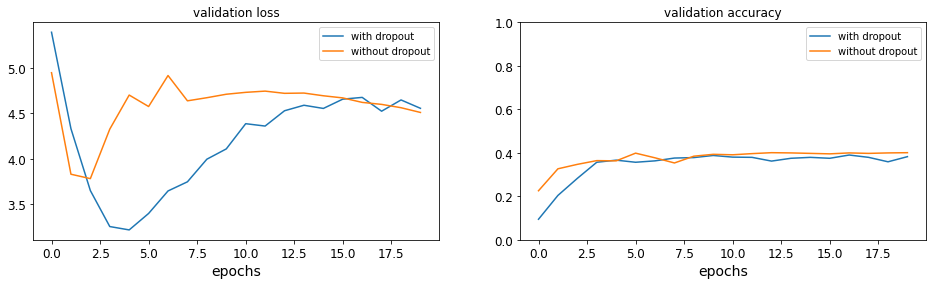

In [14]:
fig = plt.figure(figsize=(16,4))
ax_1 = fig.add_subplot(121)
ax_1.plot(history_1.history["val_loss"], label = 'with dropout')
ax_1.plot(history_2.history["val_loss"], label = 'without dropout')
ax_1.set_title("validation loss")
ax_1.set_xlabel("epochs")
ax_1.legend()

ax_2 = fig.add_subplot(122)
ax_2.plot(history_1.history["val_accuracy"], label = 'with dropout')
ax_2.plot(history_2.history["val_accuracy"], label = 'without dropout')
ax_2.set_title("validation accuracy")
ax_2.set_xlabel("epochs")
ax_2.set_ylim(0, 1)
ax_2.legend()

plt.show()

#### Loss Plots
##### Training Set
* The loss in the training set decreased more gradual until it stablelize in a certain rate, for the model with dropout layer

##### Validation Set
* The validation loss of model with dropout layer has less noise and more regularized as seen in the plot below
* It also gradually decreased the validation loss like in the training set, for the model with dropout layer

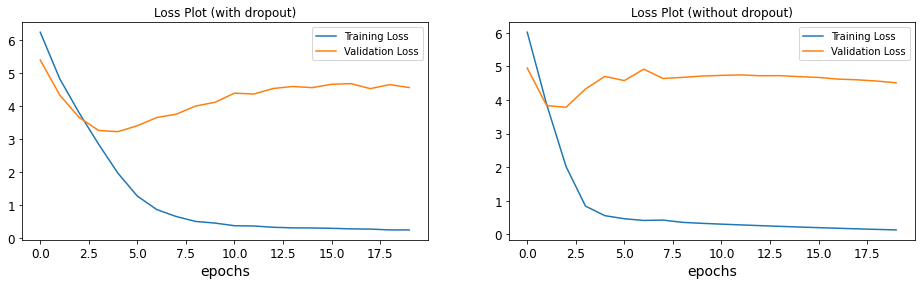

In [15]:
fig = plt.figure(figsize=(16,4))
ax_3 = fig.add_subplot(121)
ax_3.plot(history_1.history["loss"], label = 'Training Loss')
ax_3.plot(history_1.history["val_loss"], label = 'Validation Loss')
ax_3.set_title("Loss Plot (with dropout)")
ax_3.set_xlabel("epochs")
ax_3.legend()

ax_4 = fig.add_subplot(122)
ax_4.plot(history_2.history["loss"], label = 'Training Loss')
ax_4.plot(history_2.history["val_loss"], label = 'Validation Loss')
ax_4.set_title("Loss Plot (without dropout)")
ax_4.set_xlabel("epochs")
ax_4.legend()

plt.show()

### ResNet50V2 Architechture

In [16]:
resnet = keras.applications.ResNet50V2(weights = 'imagenet', include_top = True)
resnet.summary()

102875136/102869336 [==============================] - 3s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________

### One Frozen Layer
* Changed the last layer of ResNet50V2 with _Dense(num_classes, activation = 'softmax')_

In [0]:
new_layer = Dense(num_classes, activation = 'softmax')

resnet_in = resnet.input
resnet_out = new_layer(resnet.layers[-2].output)

model_3 = Model(resnet_in, resnet_out)

* All layers were frozen except for the last layer, which is the _new_layer_ that has 97 outputs

In [18]:
for l, layer in enumerate(model_3.layers[:-1]):
  layer.trainable = False

for l, layer in enumerate(model_3.layers[-1:]):
  layer.trainable = True

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [19]:
history_3 = model_3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 20)

Train on 4346 samples, validate on 931 samples
Epoch 1/20
4346/4346 [==============================] - 17s 4ms/step - loss: 1.7538 - accuracy: 0.6275 - val_loss: 0.5378 - val_accuracy: 0.8593
Epoch 2/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.3438 - accuracy: 0.9342 - val_loss: 0.4449 - val_accuracy: 0.8818
Epoch 3/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.1802 - accuracy: 0.9703 - val_loss: 0.4086 - val_accuracy: 0.8926
Epoch 4/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.1169 - accuracy: 0.9809 - val_loss: 0.3935 - val_accuracy: 0.8990
Epoch 5/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.0802 - accuracy: 0.9915 - val_loss: 0.3831 - val_accuracy: 0.8980
Epoch 6/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.0606 - accuracy: 0.9942 - val_loss: 0.4071 - val_accuracy: 0.8990
Epoch 7/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.0458

In [0]:
loss_3, accuracy_3 = model_3.evaluate(x_test, y_test, verbose=0)

result_list = []
result_list.append(["1 layer frozen", loss_3, accuracy_3])

result_pd.loc[len(result_pd)] = result_list[0]

#### Data Augmentation Application
##### These data augmentations are chosen because they are the typical variations in images
* _rotation_range_ of 90, due to images can be landscape or portrait which has 90 degree difference from each other
* _width_shift_range_ and _height_shift_range_ of 0.1, due to images are shifted only by 10% which means the subject is still whole in the image
* _zoom_range_ 0.8 to 1.3, due to the subject is still recognizable in 0.8 zoom out, whole and recognizable in 1.2 zoom in
* _horizontal_flip_ is True
* _fill_mode_ is nerest, due to the probability of the missing piece in an image has same color or color gradient to it's neighbor is high
* _brightness_range_ is 0.3 to 1.2, due to the subject is still recognizable in with this brightness range

In [0]:
datagen = ImageDataGenerator(rotation_range=90,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = (0.8, 1.3),
                             horizontal_flip = True,
                             fill_mode = 'nearest',
                             brightness_range = (0.3, 1.2))

x_train_aug = x_train
datagen.fit(x_train_aug)

In [22]:
batch_size = 32
history_5 = model_3.fit(datagen.flow(x_train_aug, y_train, batch_size), steps_per_epoch = len(x_train_aug)/batch_size, epochs = 20, 
                        validation_data = (x_val, y_val))

Epoch 1/20
136/135 [==============================] - 55s 407ms/step - loss: 0.9496 - accuracy: 0.7570 - val_loss: 0.6997 - val_accuracy: 0.8765
Epoch 2/20
136/135 [==============================] - 54s 394ms/step - loss: 0.6099 - accuracy: 0.8272 - val_loss: 0.6614 - val_accuracy: 0.8786
Epoch 3/20
136/135 [==============================] - 54s 394ms/step - loss: 0.4908 - accuracy: 0.8587 - val_loss: 0.6640 - val_accuracy: 0.8786
Epoch 4/20
136/135 [==============================] - 54s 397ms/step - loss: 0.4471 - accuracy: 0.8695 - val_loss: 0.6309 - val_accuracy: 0.8765
Epoch 5/20
136/135 [==============================] - 54s 394ms/step - loss: 0.3781 - accuracy: 0.8845 - val_loss: 0.6776 - val_accuracy: 0.8754
Epoch 6/20
136/135 [==============================] - 54s 395ms/step - loss: 0.3417 - accuracy: 0.8962 - val_loss: 0.6581 - val_accuracy: 0.8722
Epoch 7/20
136/135 [==============================] - 54s 394ms/step - loss: 0.3219 - accuracy: 0.9011 - val_loss: 0.7025 - val_ac

In [0]:
loss_5, accuracy_5 = model_3.evaluate(x_test, y_test, verbose=0)

result_list.append(["augmented data (1 layer ResNet50)", loss_5, accuracy_5])

result_pd.loc[len(result_pd)] = result_list[1]

### Two Frozen Layers
* _Trainable Layers_ are the last convolution layer (input and output) and the last layer of the network
* The _last convolution layer_ was unfrozen due to the last layers of the network were focused on specific tasks, unlike the upper parts of the network which identifies general features. Which means the weight updates affect the accuracy and loss more
* Freezing the upper layers of the model speedup performance but decreases accuracy and increases loss

In [24]:
model_4 = Model(resnet_in, resnet_out)

for l, layer in enumerate(model_4.layers[:-6]):
  layer.trainable = False

for l, layer in enumerate(model_4.layers[-4:-1]):
  layer.trainable = False

# last layer
for l, layer in enumerate(model_4.layers[-1:]):
  layer.trainable = True

# in and out of last convolution layer
for l, layer in enumerate(model_4.layers[-6:-4]):
  layer.trainable = True

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [25]:
history_4 = model_4.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 20)

Train on 4346 samples, validate on 931 samples
Epoch 1/20
4346/4346 [==============================] - 17s 4ms/step - loss: 0.1919 - accuracy: 0.9556 - val_loss: 3.8680 - val_accuracy: 0.7444
Epoch 2/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.1216 - accuracy: 0.9659 - val_loss: 4.4519 - val_accuracy: 0.7487
Epoch 3/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.0556 - accuracy: 0.9827 - val_loss: 5.3260 - val_accuracy: 0.7368
Epoch 4/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.0603 - accuracy: 0.9848 - val_loss: 5.6853 - val_accuracy: 0.7304
Epoch 5/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.0522 - accuracy: 0.9827 - val_loss: 5.8162 - val_accuracy: 0.7282
Epoch 6/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.0299 - accuracy: 0.9919 - val_loss: 4.1534 - val_accuracy: 0.7852
Epoch 7/20
4346/4346 [==============================] - 14s 3ms/step - loss: 0.0340

In [0]:
loss_4, accuracy_4 = model_4.evaluate(x_test, y_test, verbose=0)

result_list = []
result_list.append(["2 layers frozen", loss_4, accuracy_4])

result_pd.loc[len(result_pd)] = result_list[0]

#### Data Augmentation Application
* Retrained the ResNet50V2 with 2 trainable layers and augmented data as input

In [27]:
history_6 = model_4.fit(datagen.flow(x_train_aug, y_train, batch_size), steps_per_epoch = len(x_train_aug)/batch_size, epochs = 20, 
                        validation_data = (x_val, y_val))

Epoch 1/20
136/135 [==============================] - 56s 410ms/step - loss: 1.1002 - accuracy: 0.7430 - val_loss: 30.7802 - val_accuracy: 0.5328
Epoch 2/20
136/135 [==============================] - 54s 396ms/step - loss: 0.6092 - accuracy: 0.8288 - val_loss: 21.2498 - val_accuracy: 0.6058
Epoch 3/20
136/135 [==============================] - 54s 397ms/step - loss: 0.4756 - accuracy: 0.8610 - val_loss: 19.5843 - val_accuracy: 0.6176
Epoch 4/20
136/135 [==============================] - 54s 394ms/step - loss: 0.3968 - accuracy: 0.8836 - val_loss: 12.5217 - val_accuracy: 0.6896
Epoch 5/20
136/135 [==============================] - 54s 394ms/step - loss: 0.3343 - accuracy: 0.9008 - val_loss: 16.6338 - val_accuracy: 0.6810
Epoch 6/20
136/135 [==============================] - 54s 395ms/step - loss: 0.3140 - accuracy: 0.9050 - val_loss: 12.8128 - val_accuracy: 0.7111
Epoch 7/20
136/135 [==============================] - 54s 397ms/step - loss: 0.2781 - accuracy: 0.9139 - val_loss: 13.8224 -

### Validation Loss and Accuracy Plot
* As observed in the plot the validation accuracy per epoch of the model with 2 frozen layers is lower by 10% to 15%, due to more trainable parameters in which each weights are updated per epoch
* A huge discrepancy in validation loss plot is seen for the two models. 2 trainable layers has very high validation loss compared to 1 trainable layer model

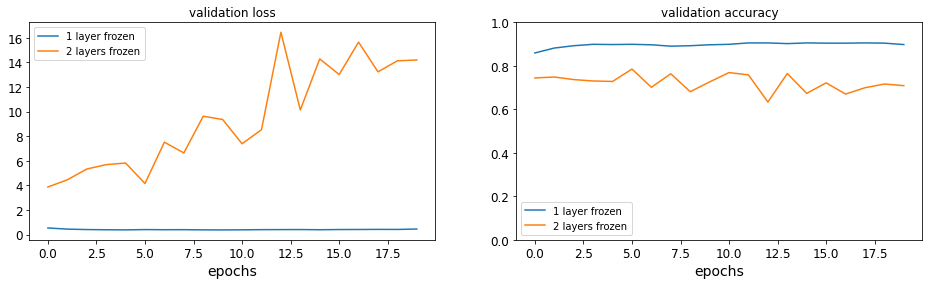

In [28]:
fig = plt.figure(figsize=(16,4))
ax_5 = fig.add_subplot(121)
ax_5.plot(history_3.history["val_loss"], label = '1 layer frozen')
ax_5.plot(history_4.history["val_loss"], label = '2 layers frozen')
ax_5.set_title("validation loss")
ax_5.set_xlabel("epochs")
ax_5.legend()

ax_6 = fig.add_subplot(122)
ax_6.plot(history_3.history["val_accuracy"], label = '1 layer frozen')
ax_6.plot(history_4.history["val_accuracy"], label = '2 layers frozen')
ax_6.set_title("validation accuracy")
ax_6.set_xlabel("epochs")
ax_6.set_ylim(0, 1)
ax_6.legend()

plt.show()

### Test Loss and Accuracy
#### Frozen: 1 Layer vs 2 Layers
* The validation and test loss drastically increased with 2 trainable layers architecture
* The validation and test accuracy decreased 10% - 15%,  with 2 trainable layers in 

#### Data Augmentation effects in model accuracy
* For the 1 trainable layer model, the data augmentation affects the accuracy and loss negatively. Test Accuracy decreased and test lost increased
* Data Augmentation affects the 2 trainable layer model positively, increased the accuracy and slightly decreased the the test loss

#### Test Result Comparison
* The data augmentation decreased the test loss in 2 trainable layers, but the loss is still high compared with the other models
* Though the test loss of the 2 trainable layers model is high compared to the rest of the models, the accuracy is higher compared to the CNN model that was built from scratch
* 1 trainable layer model gives the best result for both original input data and augmented data. Achieving the highest accuracy and the lowest loss.


In [29]:
loss_6, accuracy_6 = model_4.evaluate(x_test, y_test, verbose=0)

result_list.append(["augmented data (2 layers ResNet50)", loss_6, accuracy_6])

result_pd.loc[len(result_pd)] = result_list[1]
result_pd

,Model,Loss,Accuracy
0,with Dropout,4.405936,0.386266
1,without Dropout,4.074606,0.420601
2,1 layer frozen,0.392113,0.904506
3,augmented data (1 layer ResNet50),0.724169,0.864807
4,2 layers frozen,13.510264,0.715665
5,augmented data (2 layers ResNet50),9.773010,0.773605
